# DS-7331 Machine Learning Mini Project
## Airbnb Price Data - Logistic and SVM
### Allen Miller, Ana Glaser, Jake Harrison, Lola Awodipe

https://nbviewer.jupyter.org/github/allenmiller17/SMU_7331_ML1_Project_1/blob/main/Project_1_Final_Write_Up.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

import numpy as np
from scipy import stats

from sklearn import metrics

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
data_path = "/content/drive/My Drive/DLCP/airbnb.csv"

In [5]:
pdata = pd.read_csv(data_path)

In [6]:
#importing the data
#pdata = pd.read_csv("airbnb.csv")
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 non-null

### Business Understanding

In [7]:
pdata = pdata.dropna()

In [8]:
pdata.skew()

id                     -0.255823
log_price               0.377120
accommodates            2.119839
bathrooms               3.705744
cleaning_fee           -1.701312
latitude               -0.649299
longitude              -0.502707
number_of_reviews       3.028550
review_scores_rating   -3.325985
bedrooms                1.874469
beds                    3.138750
dtype: float64

In [9]:
z = pdata[pdata['number_of_reviews']> 100]
for i in list (z[z['number_of_reviews']> 100].index):
    pdata.loc[i,'number_of_reviews'] = 100

In [10]:
y = pdata[pdata['review_scores_rating']< 80]
for i in list (y[y['review_scores_rating']< 80].index):
    pdata.loc[i,'review_scores_rating'] = 80

In [11]:
x = pdata[pdata['beds']> 5]
for i in list (x[x['beds']> 5].index):
    pdata.loc[i,'beds'] = 5

In [12]:
value_list = ["Apartment"]
boolean_series = ~pdata.property_type.isin(value_list)
filtered_df = pdata[boolean_series]

filtered_df.head(100)

for i in list (filtered_df.index):
    pdata.loc[i,'property_type'] = "other"

pdata["region"] = pd.cut(pdata.longitude,[-200,-100,0],2,labels=["West","East"])

In [13]:
pdata.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,region
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,8/5/2017,t,f,100%,6/19/2017,t,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,East
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,4/30/2017,t,t,100%,10/25/2016,t,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,East
4,3808709,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",5/12/2015,t,t,100%,3/1/2015,t,1/22/2017,38.925627,-77.034596,Columbia Heights,4,80.0,20009,0.0,1.0,East
5,12422935,4.442651,Apartment,Private room,2,1.0,Real Bed,strict,True,SF,Beautiful private room overlooking scenic view...,8/27/2017,t,t,100%,6/7/2017,t,9/5/2017,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,West
7,13971273,4.787492,other,Entire home/apt,2,1.0,Real Bed,moderate,True,LA,Arguably the best location (and safest) in dow...,12/16/2016,t,t,100%,5/18/2013,f,4/12/2017,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0,West


In [14]:
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                "property_type":     {"Apartment": 1, "other": 2},
                    }

pdata=pdata.replace(replaceStruct)
pdata.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,region
1,6304928,5.129899,1,Entire home/apt,7,1.0,Real Bed,strict,1,NYC,Enjoy travelling during your stay in Manhattan...,8/5/2017,t,0,100%,6/19/2017,1,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,East
2,7919400,4.976734,1,Entire home/apt,5,1.0,Real Bed,moderate,1,NYC,The Oasis comes complete with a full backyard ...,4/30/2017,t,1,100%,10/25/2016,1,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,East
4,3808709,4.744932,1,Entire home/apt,2,1.0,Real Bed,moderate,1,DC,"Cool, cozy, and comfortable studio located in ...",5/12/2015,t,1,100%,3/1/2015,1,1/22/2017,38.925627,-77.034596,Columbia Heights,4,80.0,20009,0.0,1.0,East
5,12422935,4.442651,1,Private room,2,1.0,Real Bed,strict,1,SF,Beautiful private room overlooking scenic view...,8/27/2017,t,1,100%,6/7/2017,1,9/5/2017,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,West
7,13971273,4.787492,2,Entire home/apt,2,1.0,Real Bed,moderate,1,LA,Arguably the best location (and safest) in dow...,12/16/2016,t,1,100%,5/18/2013,0,4/12/2017,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0,West


In [15]:
pdata.nunique()

id                        42775
log_price                   643
property_type                 2
room_type                     3
accommodates                 16
bathrooms                    17
bed_type                      5
cancellation_policy           5
cleaning_fee                  2
city                          6
description               42424
first_review               2489
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           77
host_since                 3000
instant_bookable              2
last_review                1100
latitude                  42758
longitude                 42734
neighbourhood               590
number_of_reviews           100
review_scores_rating         21
zipcode                     577
bedrooms                     11
beds                          6
region                        2
dtype: int64

In [16]:
oneHotCols=["room_type","bed_type","city","cancellation_policy","region"]
pdata.drop(['description','host_response_rate','first_review','host_since','last_review','zipcode','id','latitude','longitude','neighbourhood','cleaning_fee','host_has_profile_pic'], axis=1, inplace=True)
pdata=pd.get_dummies(pdata, columns=oneHotCols)
pdata.head(10)

,log_price,property_type,accommodates,bathrooms,host_identity_verified,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,region_West,region_East
1,5.129899,1,7,1.0,0,1,6,93.0,3.0,3.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,4.976734,1,5,1.0,1,1,10,92.0,1.0,3.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
4,4.744932,1,2,1.0,1,1,4,80.0,0.0,1.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
5,4.442651,1,2,1.0,1,1,3,100.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0
7,4.787492,2,2,1.0,1,0,9,93.0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
8,4.787492,2,2,1.0,0,0,100,99.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
10,4.605170,1,2,1.0,1,0,82,93.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
11,5.010635,2,4,1.5,1,0,29,97.0,2.0,2.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
13,5.298317,1,6,1.5,1,1,13,89.0,2.0,3.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
17,4.595120,2,2,2.0,1,0,12,88.0,1.0,1.0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1


In [17]:

X = pdata.drop('property_type',axis=1)     
Y = pdata['property_type']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train.head()

,log_price,accommodates,bathrooms,host_identity_verified,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,city_Boston,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,region_West,region_East
36694,4.521789,2,1.0,1,0,100,99.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0
50548,5.010635,3,1.0,1,0,10,100.0,1.0,2.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1
7142,4.094345,2,1.0,1,0,34,92.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
36775,5.634790,2,1.0,0,1,3,87.0,0.0,1.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
65349,5.393628,4,1.0,1,0,3,100.0,1.0,1.0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1


In [18]:
from sklearn.preprocessing import StandardScaler
ScaleObj = StandardScaler()
ScaleObj.fit(x_train)

X_train_scaled = ScaleObj.transform(x_train)
X_test_scaled = ScaleObj.transform(x_test)

In [19]:
print("{0:0.2f}% data is in training set".format((len(x_train)/len(pdata.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(pdata.index)) * 100))

80.00% data is in training set
20.00% data is in test set


In [20]:
modelGRID = LogisticRegression()

parameters = {'penalty': ['l2'],
             'C': [.001,.75,10],
             'solver': ['newton-cg','liblinear','sag','saga'],
              'max_iter':[100,500]
            }

In [21]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(modelGRID,n_jobs=25,param_grid=parameters,cv=3,scoring='accuracy')
gs.fit(X_train_scaled, y_train)
gs.best_params_

{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [22]:
gs.cv_results_['params']

[{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'},
 {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'},
 {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'},
 {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'},
 {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'},
 {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'},
 {'C': 0.75, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 0.75, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'},
 {'C': 0.75, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'},
 {'C': 0.75, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'},
 {'C': 0.75, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 0.75, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'},
 {'C': 0.75, 'max_iter': 500, '

In [23]:
gs.cv_results_['mean_test_score']

array([0.73416124, 0.73734649, 0.73416124, 0.73416124, 0.73416124,
       0.73734649, 0.73416124, 0.73416124, 0.73603149, 0.73603149,
       0.73603149, 0.73603149, 0.73603149, 0.73603149, 0.73603149,
       0.73603149, 0.73603149, 0.73603149, 0.73603149, 0.73603149,
       0.73603149, 0.73603149, 0.73603149, 0.73603149])

In [24]:
train_score=[]
test_score=[]
solver = ['newton-cg','liblinear','sag','saga']
for i in solver:
    model = LogisticRegression(random_state=42,penalty='l2', C = 0.001,solver=i, max_iter=100)  # changing values of solver
    model.fit(X_train_scaled, y_train) 
    y_predict = model.predict(X_test_scaled)     
    train_score.append(round(model.score(X_train_scaled, y_train),3))
    test_score.append(round(model.score(X_test_scaled, y_test),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['newton-cg', 'liblinear', 'sag', 'saga']

[0.736, 0.738, 0.736, 0.736]

[0.733, 0.735, 0.733, 0.733]


In [33]:

# Fit the model on train
modelFINAL = LogisticRegression(random_state=42,penalty='l2', C = 0.001,solver='liblinear', max_iter=100)
modelFINAL.fit(X_train_scaled, y_train)
#predict on test
y_predict = modelFINAL.predict(X_test_scaled)
model_score = round(modelFINAL.score(X_test_scaled,y_test),ndigits=3)
print(model_score)


0.735


In [27]:
modelFINAL.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [26]:
#class example
weights = modelFINAL.coef_.T
variable_names = x_train.columns
for coef,name in zip(weights, variable_names):
    print(name, 'has weight of', round(coef[0],ndigits=2))

log_price has weight of -0.06
accommodates has weight of 0.1
bathrooms has weight of 0.29
host_identity_verified has weight of -0.03
instant_bookable has weight of -0.03
number_of_reviews has weight of 0.07
review_scores_rating has weight of 0.11
bedrooms has weight of 0.22
beds has weight of 0.11
room_type_Entire home/apt has weight of -0.23
room_type_Private room has weight of 0.23
room_type_Shared room has weight of 0.01
bed_type_Airbed has weight of -0.01
bed_type_Couch has weight of -0.03
bed_type_Futon has weight of 0.0
bed_type_Pull-out Sofa has weight of -0.0
bed_type_Real Bed has weight of 0.01
city_Boston has weight of 0.05
city_Chicago has weight of -0.0
city_DC has weight of 0.19
city_LA has weight of 0.17
city_NYC has weight of -0.29
city_SF has weight of 0.04
cancellation_policy_flexible has weight of 0.01
cancellation_policy_moderate has weight of 0.03
cancellation_policy_strict has weight of -0.03
cancellation_policy_super_strict_30 has weight of -0.03
cancellation_poli

Trainig accuracy 0.74

Testing accuracy 0.73

Confusion Matrix


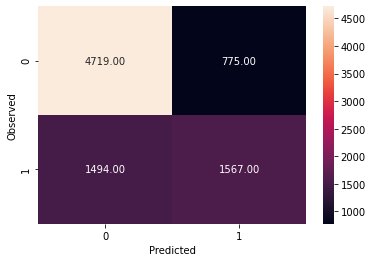

None
              precision    recall  f1-score   support

           1       0.76      0.86      0.81      5494
           2       0.67      0.51      0.58      3061

    accuracy                           0.73      8555
   macro avg       0.71      0.69      0.69      8555
weighted avg       0.73      0.73      0.73      8555



In [28]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

print("Trainig accuracy",round(modelFINAL.score(X_train_scaled,y_train),ndigits=2))
print()
print("Testing accuracy",round(modelFINAL.score(X_test_scaled, y_test),ndigits=2))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))

print(classification_report(y_test,y_predict))

In [29]:
#https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2"],
}
clf = SGDClassifier()
grid = GridSearchCV(clf, param_grid=params, cv=3)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)

{'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'}


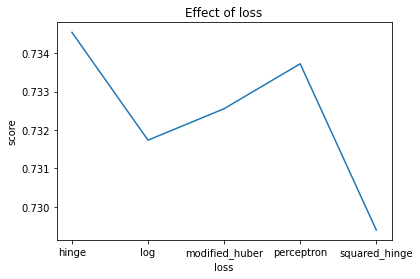

In [46]:
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    clf = SGDClassifier(loss='hinge', penalty="l2", alpha=0.001, max_iter=1000)
    clf.fit(X_train_scaled, y_train)
    scores.append(clf.score(X_test_scaled, y_test))
plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores)

In [31]:
svm_model = SGDClassifier(alpha= 0.001, loss= 'hinge', penalty='l2')
svm_model.fit(X_train_scaled, y_train)
grid_predictions = svm_model.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, grid_predictions)))

Accuracy: 0.73


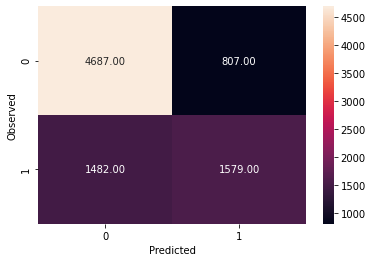

None
              precision    recall  f1-score   support

           1       0.76      0.85      0.80      5494
           2       0.66      0.52      0.58      3061

    accuracy                           0.73      8555
   macro avg       0.71      0.68      0.69      8555
weighted avg       0.72      0.73      0.72      8555



In [32]:
print(draw_cm(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))